In [1]:
%pip install pygeodyntools --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pygeotools
import torch
import torch.nn as nn
import numpy
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import TwoSlopeNorm


e:\INTERNSHIP\PINN\Code\myenv\Lib\site-packages\pygeotools\pygeotools.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Retrieving the data

In [3]:
model_path = "E:\INTERNSHIP\PINN\Code\COVOBS-x2_400reals.hdf5"

pygeo = pygeotools.pygeotools()
model_name=  "COVOBS-x2_400reals.hdf5"
pygeo.loadModel(
    modelName="COVOBS-x2_400reals.hdf5",
    modelType="covobs_hdf5",
    modelPath="COVOBS-x2_400reals.hdf5"
)


pygeo.isLoaded("COVOBS-x2_400reals.hdf5")  # Should return True

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Hp\AppData\Local\Temp\ipykernel_17576\3761006966.py:1: SyntaxWarning: invalid escape sequence '\I'
  model_path = "E:\INTERNSHIP\PINN\Code\COVOBS-x2_400reals.hdf5"


pygeotools was initialized with `verbose=True`.


True

In [4]:
# Setting the grid
pygeo.setGrid("1deg")

# Creating the context
context = {
    "lmax": 13,
    "r": pygeo.constants["rCore"]
}

In [5]:
# Computing the MF and SV
MF = pygeo.addMeasure("COVOBS-x2_400reals.hdf5", "MF", context)
SV = pygeo.addMeasure("COVOBS-x2_400reals.hdf5", "SV", context)

13


In [6]:
# Retrieving the grid
_, (thetas, phis) = pygeo.getCurrentGrid()

In [7]:
# Selecting the data
Br = pygeo.selectFromMeasure("COVOBS-x2_400reals.hdf5", MF, options={"component": "r", "time": 2020})
dBrdt = pygeo.selectFromMeasure("COVOBS-x2_400reals.hdf5", SV, options={"component": "r", "time": 2020})


In [8]:
dBrdth_full = numpy.gradient(Br,   thetas, axis=0)
dBrdph_full = numpy.gradient(Br,   phis,   axis=1)


In [9]:
def generate_patches(theta_size=30, phi_size=30, overlap=5):# 20 rows longitude, 20 cols latitude
    patches = []
# without overlap
    dtheta = theta_size - overlap
    dphi = phi_size - overlap

#going from pole to pole (0 to 180 in colatitude) by stepping in 15° chunks (because dtheta = 15)
    for i1 in range(0, 180 - theta_size + 1, dtheta):
        i2 = i1 + theta_size
        for j1 in range(0, 360 - phi_size + 1, dphi):
            j2 = j1 + phi_size

            patches.append((i1, i2, j1, j2))

    return patches
'''
This loop creates a full list of (i1, i2, j1, j2) — patches of size 20°×20°, sliding across the whole globe, overlapping 5°.

Each patch will be used to train a small PINN, then all will be stitched together into one global map.
'''
# How to use?
patches = generate_patches(theta_size=20, phi_size=20, overlap=5)

for i1, i2, j1, j2 in patches:
    ... # For each patch, we have to solve the inverse problem

### Defining the NN model

In [10]:
node_inputs = 2
node_outputs = 2
node_layer = 32
hidden_layers = 5

In [11]:
#  Defining the NN
# For now, it has one hidden layer with 32 nodes
# The activation functions are TANH
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()

        layers = []

        layers.append(nn.Linear(node_inputs, node_layer))
        layers.append(nn.Tanh())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(node_layer, node_layer))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(node_layer, node_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [12]:

r = torch.tensor(pygeo.constants["rCore"]) # placing ourselves at the CMB


def compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn):
    # Retrieving the predicted flow
    u_pred = model(inputs)

    # Retrieving the toroidal and poloidal components
    T = u_pred[:, 0:1]
    S = u_pred[:, 1:2]

    # First derivatives of T and S
    dT_dth = torch.autograd.grad(T, thetas_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dT_dph = torch.autograd.grad(T, phis_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dS_dth = torch.autograd.grad(S, thetas_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]
    dS_dph = torch.autograd.grad(S, phis_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]

    eps=1e-3

    

    sin_th = torch.sin(thetas_nn).clamp(min=eps)
    cos_th = torch.cos(thetas_nn)
    tan_th = sin_th.reciprocal() * torch.sin(thetas_nn) 

    # Defining u_th and u_ph with T and S
    u_th = -dT_dph / sin_th + dS_dth
    u_ph = dT_dth + dS_dph / sin_th

    # Computing ∇h • Uh
    u_th_sin_th = u_th * sin_th
    d_u_th_sin_th_dth = torch.autograd.grad(u_th_sin_th, thetas_nn, grad_outputs=torch.ones_like(u_th_sin_th), create_graph=True, retain_graph=True)[0]
    d_u_ph_dph = torch.autograd.grad(u_ph, phis_nn, grad_outputs=torch.ones_like(u_ph), create_graph=True, retain_graph=True)[0]
    divH_uH = (1 / (r * sin_th)) * (d_u_th_sin_th_dth + d_u_ph_dph)

    # Computing ∇h Br
    gradH_Br_th = (1 / r) * dBrdth_nn
    gradH_Br_ph = (1 / (r * sin_th)) * dBrdph_nn

    # Wrapping the induction equation
    L1 = dBrdt_nn + Br_nn * divH_uH + u_th * gradH_Br_th + u_ph * gradH_Br_ph
    L1_loss = (L1**2).mean()

    """
    Computing L2
    """
    λ= 1000
    L2 = divH_uH - u_th * tan_th / r
    L2_loss = (L2**2).mean()
    L2_loss_λ = λ * L2_loss

    return L1, L1_loss, L2_loss_λ, u_th, u_ph


In [13]:
# Training over all patches
num_realizations = 1 # 5 time on each patch
epochs = 5000
λ      = 100



patch_centers=[]
loss_history = []
L1_history   = []
L2_history   = []


print(f"Number of times each patch will run: {num_realizations}")
print(f"Number of epochs: {epochs}")


patch_centers = []

# for less time consumption, I am using 50 patches
test_patches = patches[ 24:25 ] # you can slice it if u want less, that is why i created a seperate variable

print(test_patches)

print(f"Training on {len(test_patches)} patches")


#test_patches = [[]]

print(f"Number of patches: {len(patches)} but we will consider : {len(test_patches)}")

for patch_idx, (i1, i2, j1, j2) in enumerate(test_patches, start=1):
    # Skip poles and equator patches if needed
    if i1 < 10 or i2 > 170 or (i1 <= 90 <= i2):
      continue


    print(f"Processing from patch {patch_idx} Since the ones before were either equator or pole") # To know when it is starting and what is getting out of calculation


    # 1) slice the data & precomputed gradients
    Br_patch     = Br          [i1:i2, j1:j2, ...]
    dBrdt_patch  = dBrdt       [i1:i2, j1:j2, ...]
    dBrdth_patch = dBrdth_full[i1:i2, j1:j2, ...]
    dBrdph_patch = dBrdph_full[i1:i2, j1:j2, ...]

    # 2) slice the angles & mesh
    thetas_bis = thetas[i1:i2]
    phis_bis   = phis  [j1:j2]
    thg, phg   = numpy.meshgrid(thetas_bis, phis_bis, indexing="ij")
    th_flat    = thg.ravel()[:, None]
    ph_flat    = phg.ravel()[:, None]

    # 3) build torch tensors
    thetas_nn = torch.tensor(th_flat,   dtype=torch.float32, requires_grad=True)
    phis_nn   = torch.tensor(ph_flat,   dtype=torch.float32, requires_grad=True)
    Br_nn     = torch.tensor(Br_patch   .flatten()[:, None], dtype=torch.float32)
    dBrdt_nn  = torch.tensor(dBrdt_patch.flatten()[:, None], dtype=torch.float32)
    dBrdth_nn = torch.tensor(dBrdth_patch.flatten()[:, None], dtype=torch.float32)
    dBrdph_nn = torch.tensor(dBrdph_patch.flatten()[:, None], dtype=torch.float32)

    inputs = torch.cat([thetas_nn, phis_nn], dim=1)

    inputs = inputs.contiguous()


    
    

    for run in range(num_realizations):
        print(f"\n=== Training run {run+1}/{num_realizations} on patch {patch_idx} ===")

        model = CoreFlowPINN()
        with torch.no_grad():
            final_layer = model.net[-1]
            final_layer.weight += 20
            final_layer.bias.zero_()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


        from torch.optim.lr_scheduler import CosineAnnealingLR

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=1e-8 )
        

        for epoch in range(1, epochs+1):
            optimizer.zero_grad()
            _, L1_loss, L2_loss_λ, _, _ = compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn)
        
            Loss_main = L1_loss + L2_loss_λ
            Loss_main.backward()
            optimizer.step()
            scheduler.step()


            if epoch % 100 == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch:4d} | L1 {L1_loss:.2e} | L2λ {L2_loss_λ:.2e} | Total {Loss_main:.2e}")

            # record histories
            loss_history.append(Loss_main.item())
            L1_history.append(L1_loss.item())
            L2_history.append(L2_loss_λ.item())

    patch_centers.append(((i1 + i2)//2, (j1 + j2)//2))

print("Done computing for all patches.")









Number of times each patch will run: 1
Number of epochs: 5000
[(15, 35, 15, 35)]
Training on 1 patches
Number of patches: 253 but we will consider : 1
Processing from patch 1 Since the ones before were either equator or pole

=== Training run 1/1 on patch 1 ===


e:\INTERNSHIP\PINN\Code\myenv\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [400, 1], strides() = [1, 0]
param.sizes() = [400, 1], strides() = [1, 0] (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch/csrc/autograd/functions/accumulate_grad.h:218.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch  100 | L1 3.17e+05 | L2λ 7.65e-02 | Total 3.17e+05
Epoch  200 | L1 1.28e+05 | L2λ 3.58e-02 | Total 1.28e+05
Epoch  300 | L1 1.55e+05 | L2λ 3.63e-02 | Total 1.55e+05
Epoch  400 | L1 1.10e+05 | L2λ 3.37e-02 | Total 1.10e+05
Epoch  500 | L1 1.07e+05 | L2λ 3.39e-02 | Total 1.07e+05
Epoch  600 | L1 9.89e+04 | L2λ 3.24e-02 | Total 9.89e+04
Epoch  700 | L1 1.56e+05 | L2λ 4.05e-02 | Total 1.56e+05
Epoch  800 | L1 9.14e+04 | L2λ 3.18e-02 | Total 9.14e+04
Epoch  900 | L1 8.65e+04 | L2λ 3.14e-02 | Total 8.65e+04
Epoch 1000 | L1 8.86e+04 | L2λ 3.36e-02 | Total 8.86e+04
Epoch 1100 | L1 8.16e+04 | L2λ 3.13e-02 | Total 8.16e+04
Epoch 1200 | L1 7.71e+04 | L2λ 3.12e-02 | Total 7.71e+04
Epoch 1300 | L1 7.56e+05 | L2λ 3.18e-02 | Total 7.56e+05
Epoch 1400 | L1 7.28e+04 | L2λ 3.15e-02 | Total 7.28e+04
Epoch 1500 | L1 6.89e+04 | L2λ 3.17e-02 | Total 6.89e+04
Epoch 1600 | L1 6.53e+04 | L2λ 3.21e-02 | Total 6.53e+04
Epoch 1700 | L1 6.89e+04 | L2λ 3.27e-02 | Total 6.89e+04
Epoch 1800 | L1 6.21e+04 | L2λ 

 after training 1 patch, then using that same trained model on five different patches—one at the equator, one near each pole, and two random ones—to see how well it generalizes.

In [14]:
import random
import numpy as np

# ───────────────────────────────────────────────────
# C) EVALUATE on FIVE OTHER PATCHES (filtered for safety)

# 1) Build the five candidate test patches
centers      = [((i1+i2)//2, (j1+j2)//2) for (i1,i2,j1,j2) in patches]
sorted_by_lat = [p for _, p in sorted(zip(centers, patches), key=lambda cp: cp[0][0])]
patch_north = sorted_by_lat[0]
patch_south = sorted_by_lat[-1]
patch_eq    = min(patches, key=lambda p: abs(((p[0]+p[1])//2) - 90))
others      = [p for p in patches if p not in (patch_eq, patch_north, patch_south)]
patch_rand  = random.sample(others, 2)
test_patches = [patch_eq, patch_north, patch_south] + patch_rand

# 2) Define the “strictly safe” filter
def is_strictly_safe_patch(patch):
    i1, i2, j1, j2 = patch
    θc = (i1 + i2) / 2
    return (20 <= θc <= 160) and (abs(θc - 90) >= 10)

safe_tests = [p for p in test_patches if is_strictly_safe_patch(p)]
print("Safe test‐patch θ_centers:", [((i1+i2)//2) for (i1,i2,_,_) in safe_tests])

# 3) Evaluate only on those safe patches
test_centers, test_maes, test_rels = [], [], []

model.eval()  
# Disable gradient updates for model parameters once
for param in model.parameters():
    param.requires_grad = False

for (ti1, ti2, tj1, tj2) in safe_tests:
    # Slice the data & gradients
    Br_patch     = Br          [ti1:ti2, tj1:tj2]
    dBrdt_patch  = dBrdt       [ti1:ti2, tj1:tj2]
    dBrdth_patch = dBrdth_full[ti1:ti2, tj1:tj2]
    dBrdph_patch = dBrdph_full[ti1:ti2, tj1:tj2]

    # Rebuild coords with grad
    thg, phg = np.meshgrid(thetas[ti1:ti2], phis[tj1:tj2], indexing="ij")
    thetas_nn_p = torch.tensor(thg.ravel()[:,None],
                               dtype=torch.float32, requires_grad=True)
    phis_nn_p   = torch.tensor(phg.ravel()[:,None],
                               dtype=torch.float32, requires_grad=True)
    inputs_p    = torch.cat([thetas_nn_p, phis_nn_p], dim=1).contiguous()

    # Build target tensors
    Br_nn_p     = torch.tensor(Br_patch    .flatten()[:,None], dtype=torch.float32)
    dBrdt_nn_p  = torch.tensor(dBrdt_patch.flatten()[:,None], dtype=torch.float32)
    dBrdth_nn_p = torch.tensor(dBrdth_patch.flatten()[:,None], dtype=torch.float32)
    dBrdph_nn_p = torch.tensor(dBrdph_patch.flatten()[:,None], dtype=torch.float32)

    # Compute the residual on this patch
    L1, _, _, _, _ = compute_loss(
        model,
        inputs_p,
        thetas_nn_p, phis_nn_p,
        Br_nn_p, dBrdt_nn_p,
        dBrdth_nn_p, dBrdph_nn_p
    )

    # Diagnostics
    mae      = L1.abs().mean().item()
    obs_mean = dBrdt_nn_p.abs().mean().item()
    rel_err  = mae / obs_mean if obs_mean else float("nan")

    # Record and print
    center = ((ti1 + ti2)//2, (tj1 + tj2)//2)
    test_centers.append(center)
    test_maes   .append(mae)
    test_rels   .append(rel_err)

    print(f"\nPatch center {center}:")
    print(f"  MAE (L1)            = {mae:.3e}")
    print(f"  |dBr/dt|_mean (obs) = {obs_mean:.3e}")
    print(f"  Relative error      = {rel_err:.2f}")

# 4) Summary statistics
arr = np.array(test_maes)
print("\nFiltered MAE summary:")
print(f"  Min = {arr.min():.3e}")
print(f"  Max = {arr.max():.3e}")
print(f"  Mean= {arr.mean():.3e}")
print(f"  Std = {arr.std():.3e}")


Safe test‐patch θ_centers: [160, 40, 115]

Patch center (160, 340):
  MAE (L1)            = 2.172e+03
  |dBr/dt|_mean (obs) = 1.748e+03
  Relative error      = 1.24

Patch center (40, 280):
  MAE (L1)            = 1.246e+03
  |dBr/dt|_mean (obs) = 1.893e+03
  Relative error      = 0.66

Patch center (115, 145):
  MAE (L1)            = 1.571e+03
  |dBr/dt|_mean (obs) = 8.297e+02
  Relative error      = 1.89

Filtered MAE summary:
  Min = 1.246e+03
  Max = 2.172e+03
  Mean= 1.663e+03
  Std = 3.836e+02


In [15]:
print("Testing on these five patches:", test_patches)


Testing on these five patches: [(75, 95, 0, 20), (0, 20, 0, 20), (150, 170, 330, 350), (30, 50, 270, 290), (105, 125, 135, 155)]


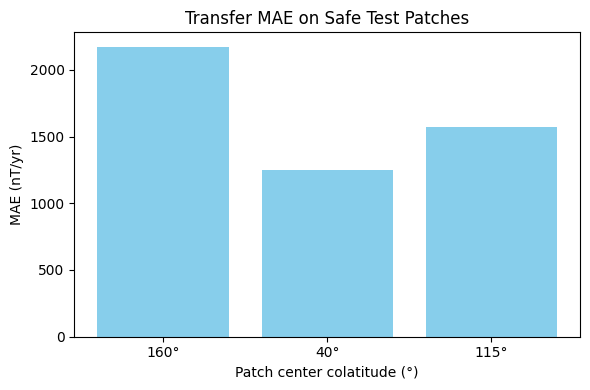

In [16]:
import matplotlib.pyplot as plt

labels = [f"{c[0]}°" for c in test_centers]  # θ_centers of your safe patches

plt.figure(figsize=(6,4))
plt.bar(labels, test_maes, color="skyblue")
plt.xlabel("Patch center colatitude (°)")
plt.ylabel("MAE (nT/yr)")
plt.title("Transfer MAE on Safe Test Patches")
plt.tight_layout()
plt.show()


In [17]:
import os
import torch



theta_size = 30
phi_size   = 30



# make sure outputs folder exists
out_dir_1 = "training_outputs"
os.makedirs(out_dir_1, exist_ok=True)

# build your params dict with only what you want
checkpoint = {
    "params": {
        "model_name":     model_name,
        "node_inputs":    node_inputs,
        "node_outputs":   node_outputs,
        "node_layer":     node_layer,
        "hidden_layers":  hidden_layers,
        "learning_rate":  0.001,
        "epochs":         1000,
        "lambda":         λ,
        "patch":          (i1, i2, j1, j2),
        "theta_size":     theta_size,   # ← add your grid size here
        "phi_size":       phi_size,     # ← and here
    },
    "loss_history": loss_history,               # list of floats
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "final_epoch": epoch,
}

# save just that small dict
save_path = os.path.join(out_dir_1, "params_only_checkpoint.pth")
torch.save(checkpoint, save_path)

print(f"Saved parameters-only checkpoint to {save_path}")



Saved parameters-only checkpoint to training_outputs\params_only_checkpoint.pth


In [18]:
ckpt = torch.load(r"E:\INTERNSHIP\PINN\Code\training_outputs\params_only_checkpoint.pth")
params       = ckpt["params"]
loss_history = ckpt["loss_history"]
model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch  = ckpt["final_epoch"] + 1


### Learning

### Predictions

In [19]:

L1, L1_loss, L2_loss_λ, u_th, u_ph = compute_loss(model, inputs, thetas_nn, phis_nn, Br_nn, dBrdt_nn, dBrdth_nn, dBrdph_nn)

def plot_sv_patch(Br_nn, L1, u_ph, u_th,
                  thetas_bis, phis_bis,
                  patch_id=None,
                  a=None,
                  title=None,
                  units=None):   # <-- new


    # Choose coloring data
    data = a if a is not None else Br_nn
    if hasattr(data, 'detach'):
        data = data.detach().numpy()

    # Build lat/lon grids
    theta_grid, phi_grid = np.meshgrid(thetas_bis, phis_bis, indexing='ij')
    lat_grid = 90 - np.rad2deg(theta_grid)
    lon_grid = np.rad2deg(phi_grid)

    # Create figure + map
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True)

    
        # center zero in the colormap
    vmax = np.nanmax(np.abs(data))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=+vmax)

    sc = ax.scatter(lon_grid, lat_grid,
                    c=data,
                    cmap='seismic',   # red–white–blue
                    norm=norm,       # ensures 0→white
                    s=20,
                    transform=ccrs.PlateCarree())


    # Colorbar
    cb = plt.colorbar(sc, orientation='vertical', shrink=0.7, pad=0.05)
    cb_label = units if units else r'$\partial B_r / \partial t$ (SV)'
    cb.set_label(cb_label, fontsize=12)

 
    cb.set_ticks([-vmax, 0, vmax])


    # Title selection: use custom title if provided
    if title is not None:
        ax.set_title(title)
    else:
        default_title = f"SV Patch {patch_id}" if patch_id is not None else "SV Patch"
        ax.set_title(default_title)

    plt.tight_layout()
    return fig, ax




In [20]:
out_dir = r"E:\INTERNSHIP\PINN\Code\training_outputs\Results 5"
os.makedirs(out_dir, exist_ok=True)

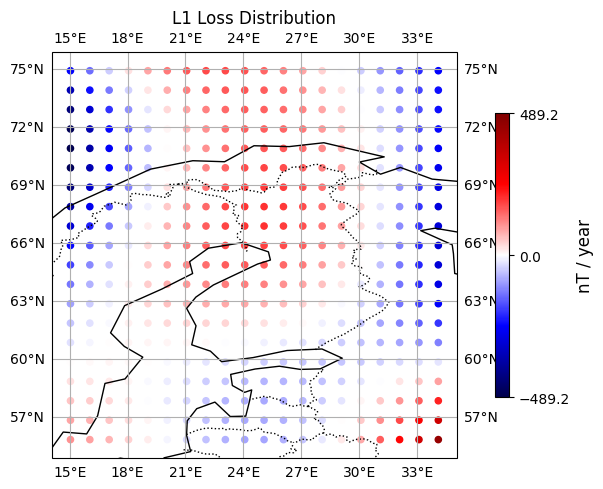

In [21]:

fig, ax = plot_sv_patch(
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=L1,
    title="L1 Loss Distribution",
    units="nT / year"         # <-- correct unit for SV residual
)





plt.savefig(os.path.join(out_dir, "L1_Loss.png"))
plt.show()


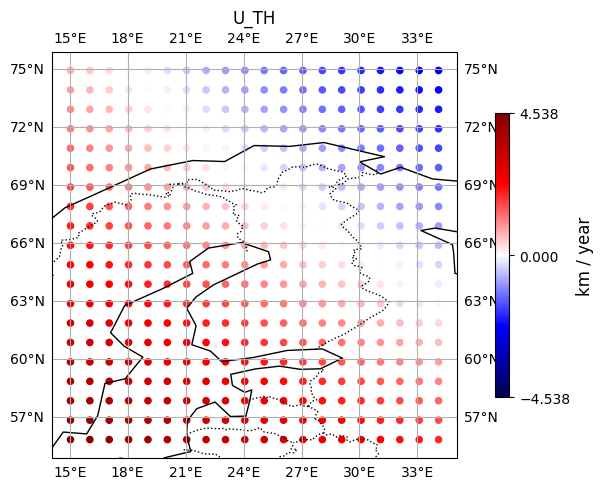

In [22]:
fig, ax = plot_sv_patch(
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=u_th.detach().numpy(),
    title="U_TH",
    units="km / year"         # <-- flow is in km/year
)

plt.savefig(os.path.join(out_dir, "Theta.png"))
plt.show()





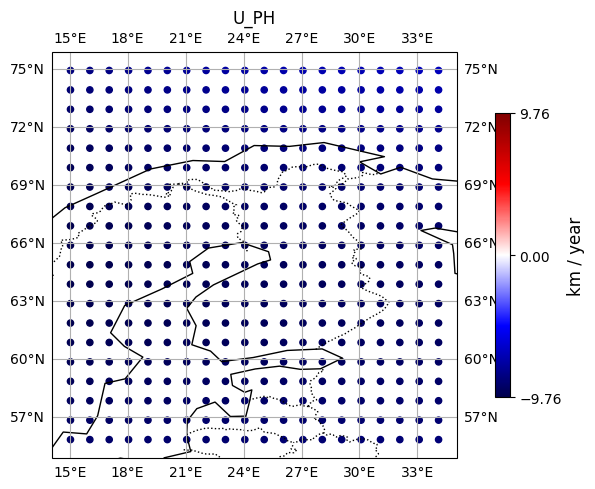

In [23]:

fig, ax = plot_sv_patch(
    Br_nn,
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=u_ph.detach().numpy(),
    title="U_PH",
    units="km / year"         # <-- flow is in km/year
)

plt.savefig(os.path.join(out_dir, "Phi.png"))
plt.show()





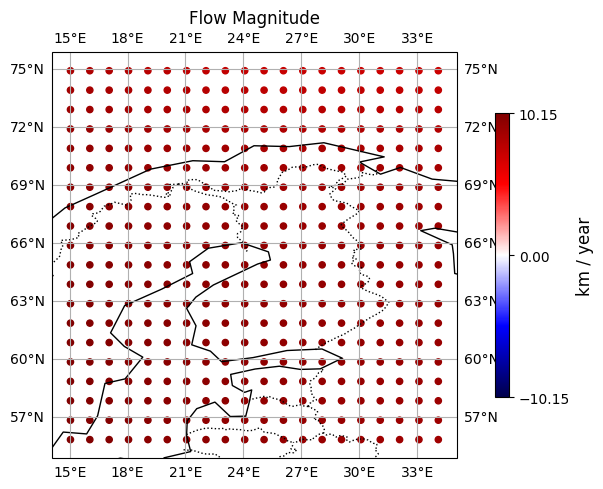

In [24]:
flow_speed = torch.sqrt(u_ph**2 + u_th**2).detach().numpy()
fig, ax = plot_sv_patch(
    Br_nn, L1, u_ph, u_th,
    thetas_bis, phis_bis,
    a=flow_speed,
    title="Flow Magnitude",
    units="km / year"
)


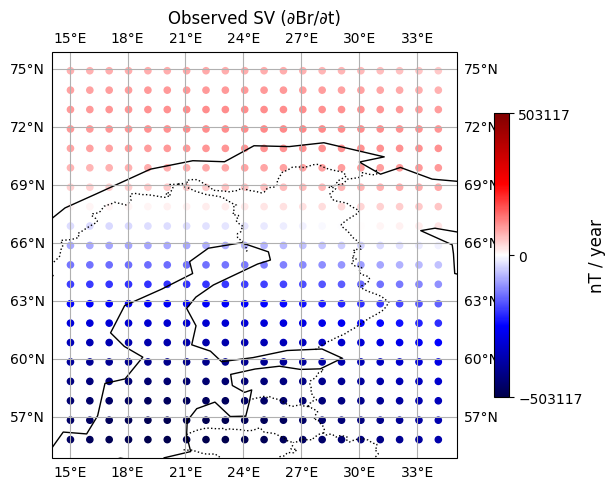

In [25]:
fig, ax = plot_sv_patch(
    Br_nn,          # observed SV values
    L1,
    u_ph,
    u_th,
    thetas_bis,
    phis_bis,
    patch_id=1,
    a=Br_nn,        # now color by the actual SV
    title="Observed SV (∂Br/∂t)",
    units="nT / year"
)
plt.savefig(os.path.join(out_dir, "SV_Observed.png"))
plt.show()


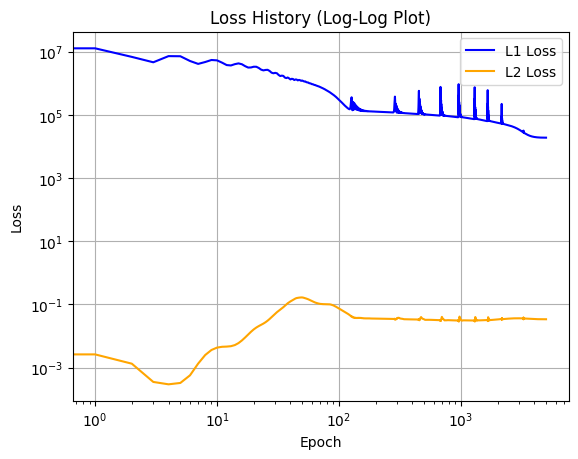

In [26]:
import matplotlib.pyplot as plt
import torch


loss_history_np1 = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in L1_history]
loss_history_np2 = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in L2_history]

plt.loglog(loss_history_np1, label='L1 Loss', color='blue')
plt.loglog(loss_history_np2, label='L2 Loss', color='orange')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Log-Log Plot)')
plt.grid(True)
plt.savefig(os.path.join(out_dir, "Loss_L1_L2.png"))
plt.show()





Part 2:

Training PINN on a region that spans all colatitudes (θ from 0° at the North Pole down to 180° at the South Pole) but only a narrow longitude band (φ = 0°–30°). That way the network sees the full variation in latitude during training.
So summary: Trained on a slice that covers all latitudes (θ from 0° to 180°)  and Tested that exact same model on five other φ bands (30–60, 60–90, 90–120, 120–150, 150–180)

In [ ]:
# ───────────────────────────────────────────────────
# D) LATITUDE‑SLICE TRANSFERABILITY TEST

# 1) Define & slice the training band φ∈[0,30]
phi0, phi1 = 0, 30
i1, i2, j1, j2 = 0, 180, phi0, phi1

L1_history_2 = []
L2_history_2 =[]
# Slice data & gradients for training
Br_train     = Br          [i1:i2, j1:j2]
dBrdt_train  = dBrdt       [i1:i2, j1:j2]
dBrdth_train = dBrdth_full[i1:i2, j1:j2]
dBrdph_train = dBrdph_full[i1:i2, j1:j2]

# Build coords & tensors
thg, phg      = np.meshgrid(thetas[i1:i2], phis[j1:j2], indexing="ij")
thetas_nn_t   = torch.tensor(thg.ravel()[:,None], dtype=torch.float32, requires_grad=True)
phis_nn_t     = torch.tensor(phg.ravel()[:,None], dtype=torch.float32, requires_grad=True)
inputs_t      = torch.cat([thetas_nn_t, phis_nn_t], dim=1)
Br_nn_t       = torch.tensor(Br_train   .flatten()[:,None], dtype=torch.float32)
dBrdt_nn_t    = torch.tensor(dBrdt_train.flatten()[:,None], dtype=torch.float32)
dBrdth_nn_t   = torch.tensor(dBrdth_train.flatten()[:,None], dtype=torch.float32)
dBrdph_nn_t   = torch.tensor(dBrdph_train.flatten()[:,None], dtype=torch.float32)

# 2) Train the slice model
model_slice = CoreFlowPINN()
opt         = torch.optim.Adam(model_slice.parameters(), lr=1e-3, weight_decay=1e-5)
sched       = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-8)

model_slice.train()
for epoch in range(1, epochs+1):
    opt.zero_grad()
    _, L1_slice, L2_slice, _, _ = compute_loss(
        model_slice, inputs_t,
        thetas_nn_t, phis_nn_t,
        Br_nn_t, dBrdt_nn_t, dBrdth_nn_t, dBrdph_nn_t
    )
    loss = L1_slice + L2_slice
    loss.backward()
    opt.step()
    sched.step()
    L1_history_2 = [L1_slice]
    L2_history_2 =[L2_slice]

    if epoch % 500 == 0:
        print(f"[Slice] Epoch {epoch:4d} | Total {loss:.2e} | L1 {L1_slice:.2e}")









# 3) Define & filter test φ‑bands
test_slices = [
    (0,180,  30,  60),
    (0,180,  60,  90),
    (0,180,  90, 120),
    (0,180, 120, 150),
    (0,180, 150, 180),
]

# Optionally drop first/last 2 θ‐rows to avoid poles
def is_safe_slice(i1,i2):
    return (i1 >= 2 and i2 <= 178)

safe_slices = [
    (ti1,ti2,tj1,tj2)
    for (ti1,ti2,tj1,tj2) in test_slices
    if is_safe_slice(ti1,ti2)
]

# 4) Evaluate on test bands
slice_centers, slice_maes = [], []
model_slice.eval()
# disable parameter grads
for p in model_slice.parameters(): p.requires_grad=False

for (ti1,ti2,tj1,tj2) in safe_slices:
    # slice data & build inputs_p as above...
    Br_p     = Br          [ti1:ti2, tj1:tj2]
    dBrdt_p  = dBrdt       [ti1:ti2, tj1:tj2]
    # rebuild coords & tensors...
    thg,phg = np.meshgrid(thetas[ti1:ti2], phis[tj1:tj2], indexing="ij")
    thetas_nn_p = torch.tensor(thg.ravel()[:,None], dtype=torch.float32, requires_grad=True)
    phis_nn_p   = torch.tensor(phg.ravel()[:,None], dtype=torch.float32, requires_grad=True)
    inputs_p    = torch.cat([thetas_nn_p, phis_nn_p], dim=1)
    dBrdt_nn_p  = torch.tensor(dBrdt_p.flatten()[:,None], dtype=torch.float32)

    # compute L1 residual
    with torch.enable_grad():
        L1, _, _, _, _ = compute_loss(
            model_slice, inputs_p,
            thetas_nn_p, phis_nn_p,
            Br_nn_p, dBrdt_nn_p, dBrdth_nn_p, dBrdph_nn_p
        )

    mae = L1.abs().mean().item()
    slice_centers.append((tj1,tj2))
    slice_maes   .append(mae)
    
    print(f"φ∈[{tj1},{tj2}] → MAE = {mae:.3e}")

# 5) Bar chart of MAE vs. φ‑band
import matplotlib.pyplot as plt
labels = [f"{a}–{b}°" for (a,b) in slice_centers]
plt.bar(labels, slice_maes, color='mediumpurple')
plt.xlabel("Test φ‑band (°)")
plt.ylabel("MAE (nT/yr)")
plt.title("Slice‐trained MAE on Other Longitude Bands")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()





[Slice] Epoch  500 | Total 1.89e+07 | L1 1.89e+07
[Slice] Epoch 1000 | Total 6.45e+06 | L1 6.45e+06
[Slice] Epoch 1500 | Total 5.76e+06 | L1 5.76e+06


In [ ]:
import matplotlib.pyplot as plt
import torch

loss_history_L1_part2 = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in L1_history_2]
loss_history_L2_part2 = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in L2_history_2]

plt.loglog(loss_history_L1_part2, label='L1 Loss', color='blue')
plt.loglog(loss_history_L2_part2, label='L2 Loss', color='orange')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History (Log-Log Plot)')
plt.grid(True)
plt.savefig(os.path.join(out_dir, "Loss_L1_L2.png"))
plt.show()



